In [3]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot, load_data, take_best_by_from_df_ps_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_ps_dict = load_data(["bb", "bb_gapproxy"])

## pfail vs pabort

In [5]:
df_ps_best = take_best_by_from_df_ps_dict(
    df_ps_dict,
    exclude=(lambda by: by in {"pred_llr", "detector_density"}),
    use_pfail_upper=False,
)

In [7]:
df_ps_best.head()

p_fail  delta_p_fail  \
n  T p     p_abort                                
72 6 0.001 1.920730e-09  0.000398      0.000001   
           2.920729e-09  0.000398      0.000001   
           3.920730e-09  0.000398      0.000001   
           4.920729e-09  0.000398      0.000001   
           5.920729e-09  0.000398      0.000001   

                                                                        by  
n  T p     p_abort                                                          
72 6 0.001 1.920730e-09  cluster_size_norm_gap_1,cluster_size_norm_inf,...  
           2.920729e-09  cluster_llr_norm_gap_0.5,cluster_size_norm_gap...  
           3.920730e-09  cluster_llr_norm_1,cluster_size_norm_0.5,clust...  
           4.920729e-09  cluster_llr_residual_sum_gap,cluster_llr_norm_...  
           5.920729e-09  cluster_llr_norm_gap_inf,cluster_size_norm_gap...

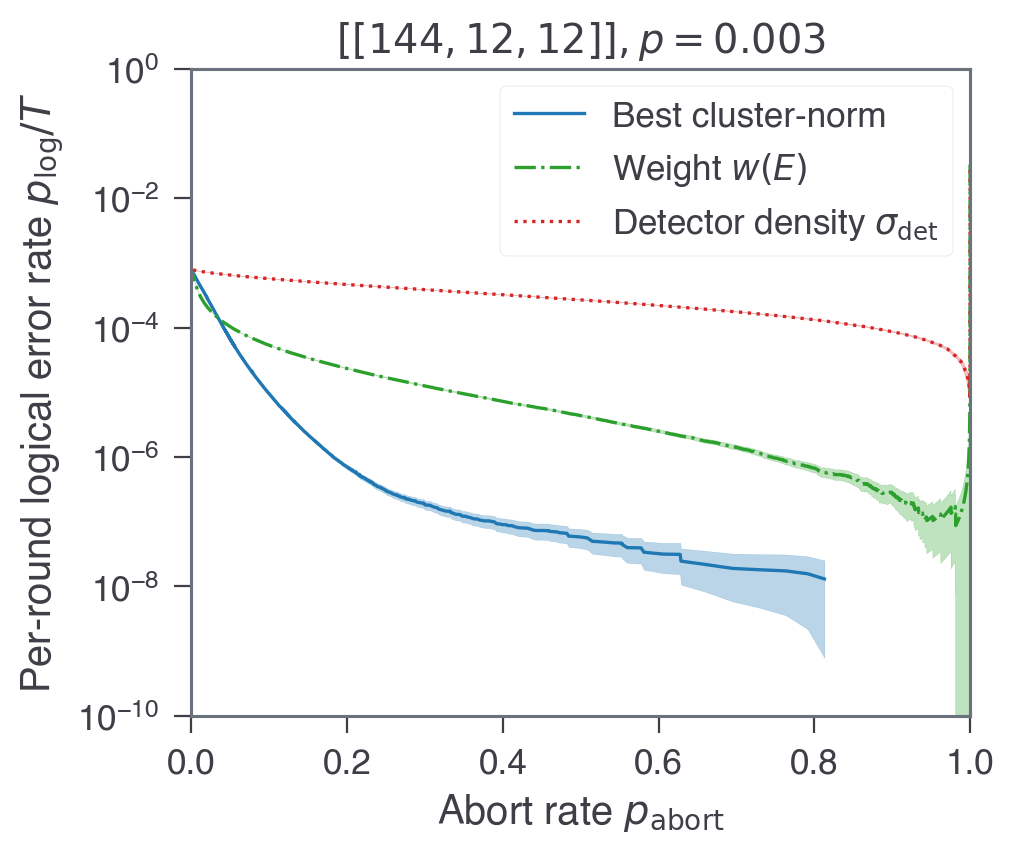

In [9]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4.5))

p = 0.003
n = 144
d = {144: 12, 72: 6}[n]


def plot(df, **kwargs):
    df = df.reset_index()
    p_abort = df["p_abort"].values
    p_fail = df["p_fail"].values / d
    delta_p_fail = df["delta_p_fail"].values / d
    error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, **kwargs)


# Best cluster norm
df_ps_d = df_ps_best.loc[idx[n, d, p, :], :]
plot(df_ps_d, label=rf"Best cluster-norm", color=COLORS(0))

# Prediction LLR
plot(
    df_ps_dict["pred_llr"].loc[idx[n, d, p, :], :],
    label=rf"Weight $w(E)$",
    color=COLORS(2),
    linestyle="-.",
)

# Detector density
plot(
    df_ps_dict["detector_density"].loc[idx[n, d, p, :], :],
    label=rf"Detector density $\sigma_\mathrm{{det}}$",
    color=COLORS(3),
    linestyle=":",
)

# ax.set_xscale("log")
ax.set_title(rf"$[[144, 12, 12]], p={p}$")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"Abort rate $p_\mathrm{abort}$")
ax.set_ylabel(r"Per-round logical error rate $p_\mathrm{log} / T$")

fig.tight_layout()

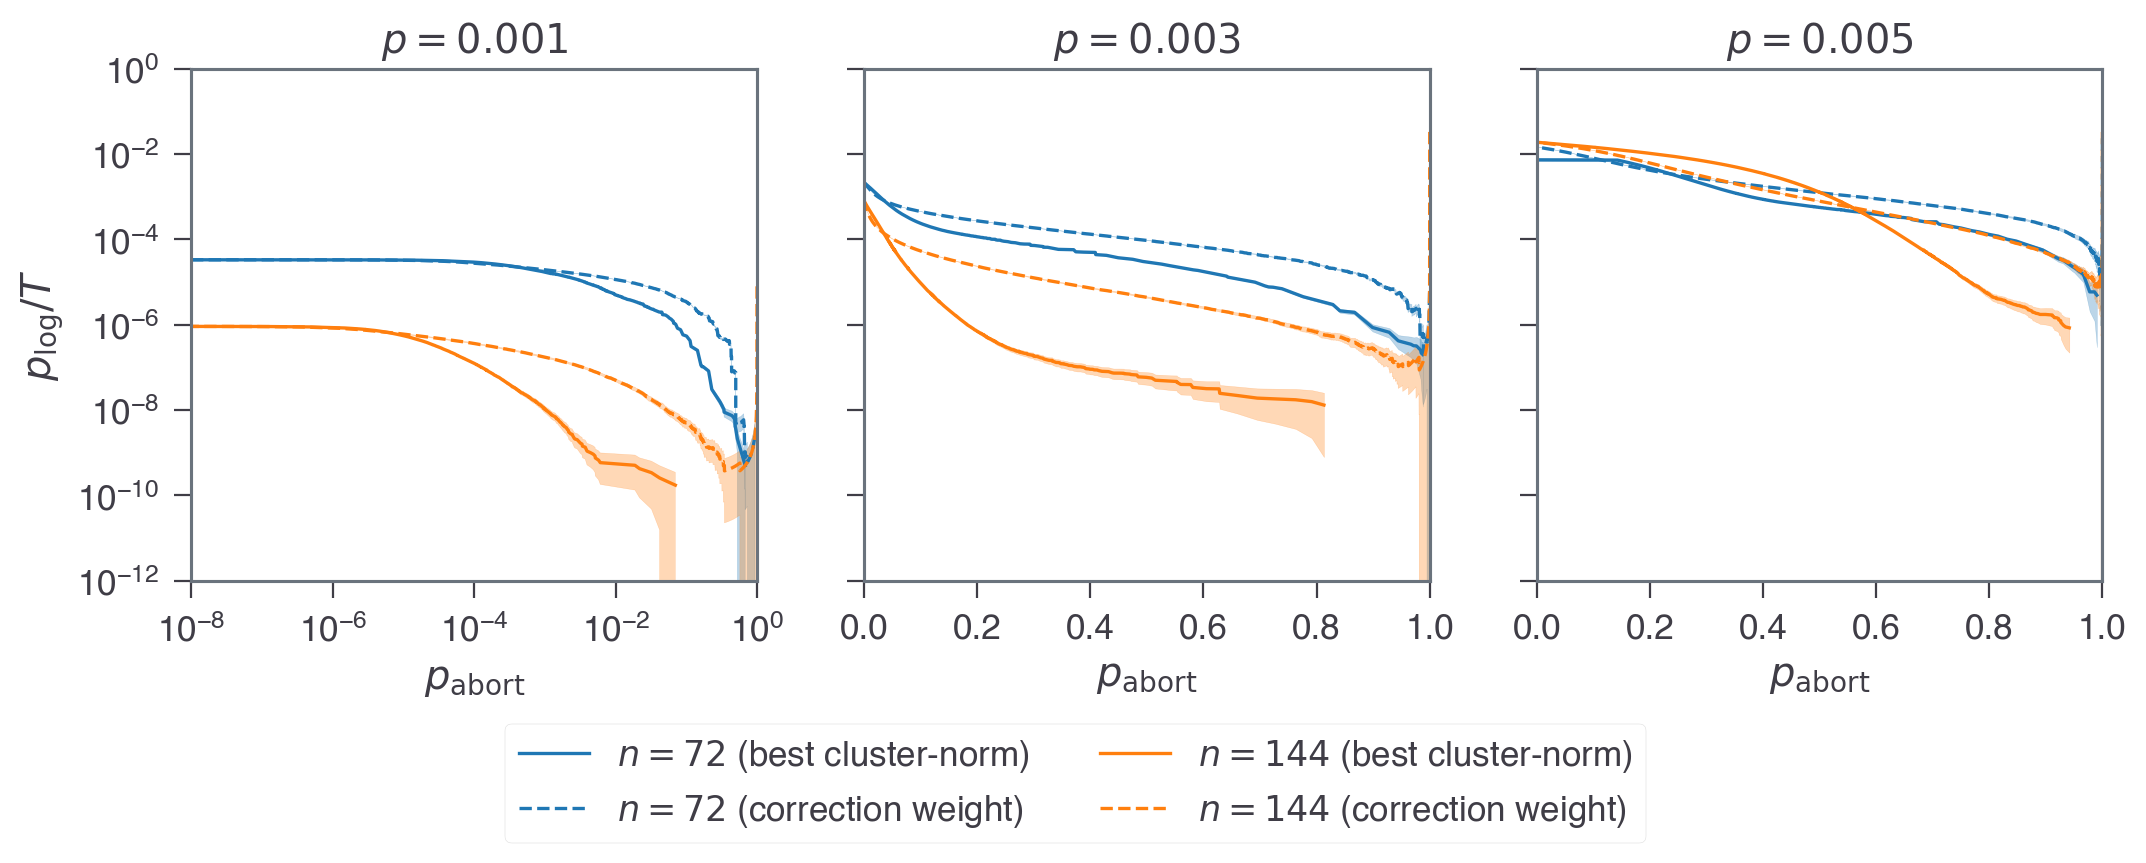

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4), sharey=True)

p_values = [0.001, 0.003, 0.005]

nlist = df_ps_best.index.get_level_values("n").unique()


def plot(df, ax, **kwargs):
    df = df.reset_index()
    p_abort = df["p_abort"].values
    p_fail = df["p_fail"].values / d
    delta_p_fail = df["delta_p_fail"].values / d
    error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, **kwargs)


for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_n, n in enumerate(nlist):
        T = {144: 12, 72: 6}[n]
        df_ps_d = df_ps_best.loc[idx[n, T, p, :], :]
        label = rf"$n={n}$ (best cluster-norm)" if i_p == 0 else None
        plot(df_ps_d, ax, label=label, color=COLORS(i_n))

        df_ps_d_pred_llr = df_ps_dict["pred_llr"].loc[idx[n, T, p, :], :]
        label = rf"$n={n}$ (correction weight)" if i_p == 0 else None
        plot(df_ps_d_pred_llr, ax, label=label, color=COLORS(i_n), linestyle="--")

    if i_p == 0:
        ax.set_xscale("log")
        ax.set_xlim(1e-8, 1)
    else:
        ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1)
    ax.set_xlabel(r"$p_\mathrm{abort}$")
    ax.set_title(f"$p = {p}$")

    if i_p == 0:
        ax.set_ylabel(r"$p_\mathrm{log} / T$")

# Add legend below the figure with 3 columns
fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

fig.tight_layout()
plt.subplots_adjust(bottom=0.25)

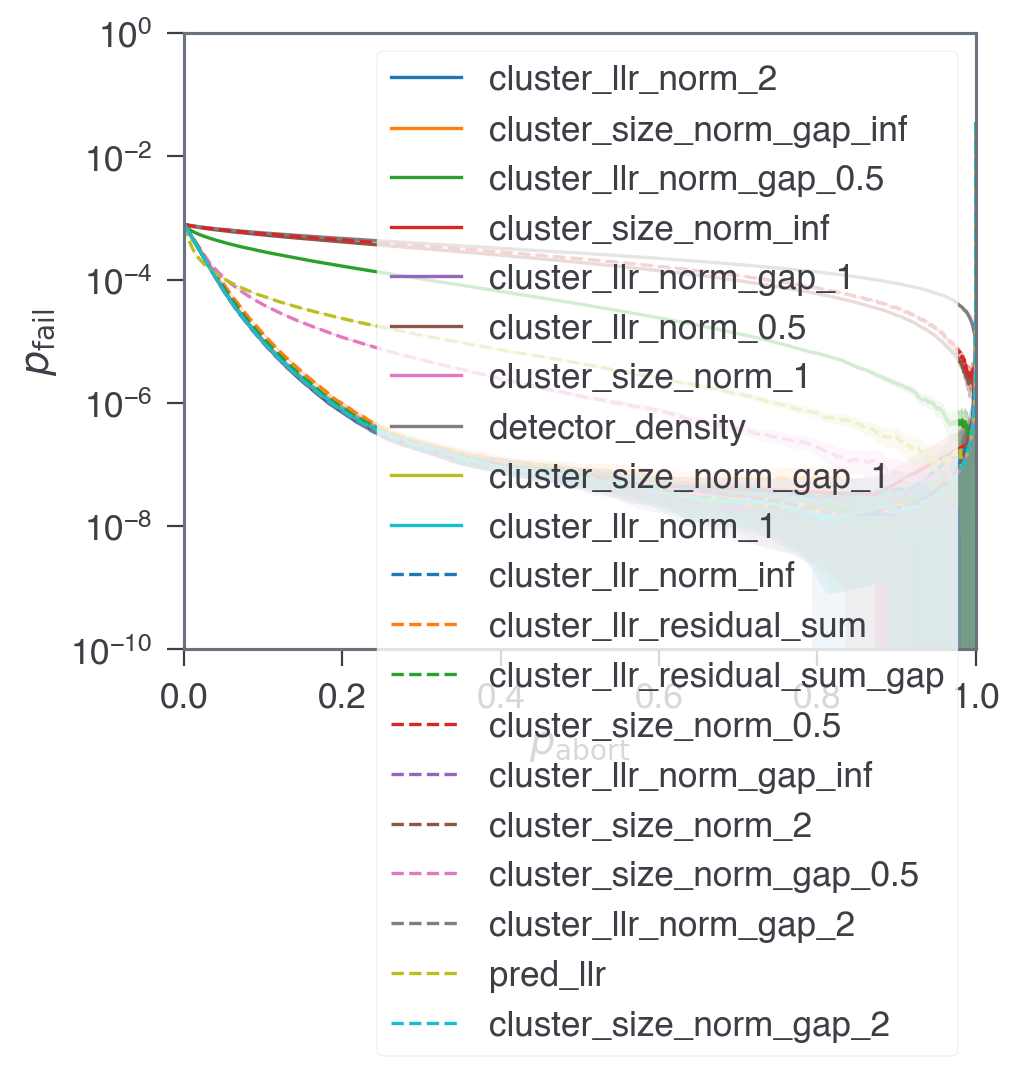

In [31]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

n = 144
d = T = {144: 12, 72: 6}[n]
p = 0.003


# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

# # First, add cluster_llr_norm_gap keys in ascending order of i (as float)
# cluster_keys = [key for key in df_ps_dict.keys() if "cluster_llr_norm_gap" in key]
# # Sort by extracting the number after 'cluster_llr_norm_gap_' as float
# cluster_keys.sort(
#     key=lambda x: (
#         float(x.split("_")[-1])
#         if x.split("_")[-1].replace(".", "").isdigit()
#         else float("inf")
#     )
# )
# ordered_keys.extend(cluster_keys)

# # Then add the other keys in specified order
# for key in ["pred_llr", "detector_density"]:
#     if key in df_ps_dict:
#         ordered_keys.append(key)

i = 0
data_plots = {}
for by in ordered_keys:
    try:
        df_ps = df_ps_dict[by].loc[idx[n, T, p, :], :]
    except KeyError:
        continue

    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

0: cluster_llr_norm_2 (1.82e-07 ± 2.88e-08)
1: cluster_llr_norm_inf (1.90e-07 ± 2.94e-08)
2: cluster_llr_norm_gap_2 (1.93e-07 ± 2.96e-08)
3: cluster_size_norm_inf (1.94e-07 ± 2.97e-08)
4: cluster_llr_norm_gap_inf (1.96e-07 ± 2.98e-08)
5: cluster_size_norm_2 (1.96e-07 ± 2.98e-08)
6: cluster_size_norm_gap_inf (1.97e-07 ± 2.99e-08)
7: cluster_size_norm_gap_2 (1.98e-07 ± 3.00e-08)
8: cluster_llr_norm_gap_1 (2.03e-07 ± 3.03e-08)
9: cluster_llr_norm_1 (2.03e-07 ± 3.03e-08)
10: cluster_size_norm_gap_1 (2.06e-07 ± 3.05e-08)
11: cluster_llr_residual_sum_gap (2.11e-07 ± 3.09e-08)
12: cluster_size_norm_1 (2.16e-07 ± 3.12e-08)
13: cluster_llr_residual_sum (2.32e-07 ± 3.24e-08)
14: cluster_size_norm_gap_0.5 (5.04e-06 ± 1.52e-07)
15: pred_llr (1.25e-05 ± 2.39e-07)
16: cluster_llr_norm_gap_0.5 (1.02e-04 ± 6.84e-07)
17: cluster_llr_norm_0.5 (3.19e-04 ± 1.20e-06)
18: cluster_size_norm_0.5 (3.52e-04 ± 1.27e-06)
19: detector_density (3.86e-04 ± 1.32e-06)


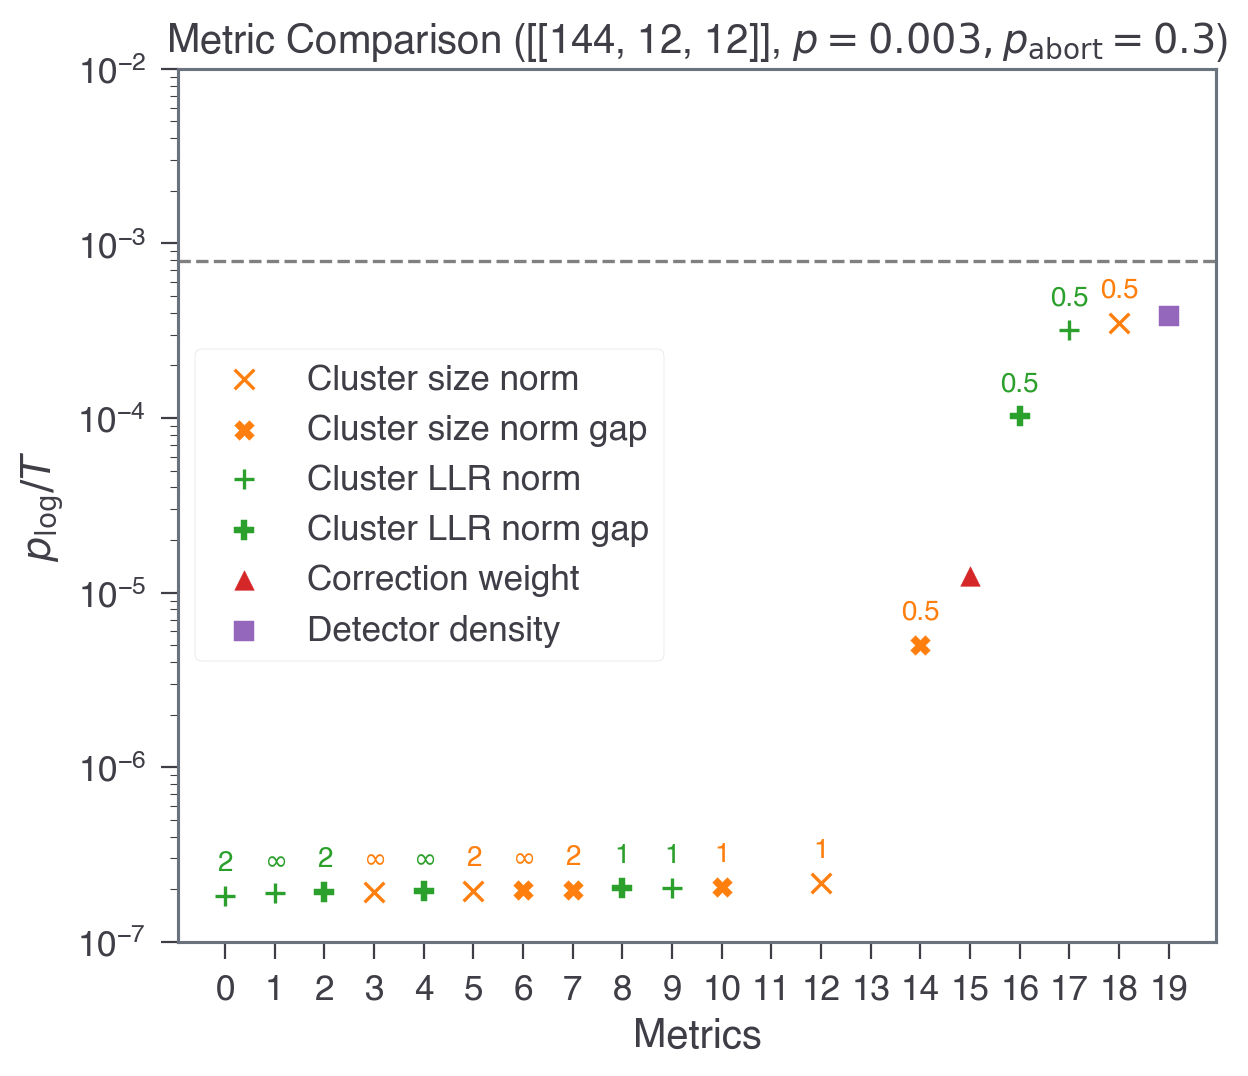

In [36]:
target = 0.3
bys, y_vals, y_errs = [], [], []

by_to_exclude = [
    "average_cluster_size",
    "average_cluster_llr",
    "matching_pred_llr",
    "matching_detector_density",
]

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    if by in by_to_exclude:
        continue
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")


def determine_group(by):
    if "cluster_size_norm" in by:
        if "gap" in by:
            group = 2
            label = "Cluster size norm gap"
            marker = "X"
        else:
            group = 1
            label = "Cluster size norm"
            marker = "x"
        color = COLORS(1)
    elif "cluster_llr_norm" in by:
        if "gap" in by:
            group = 4
            label = "Cluster LLR norm gap"
            marker = "P"
        else:
            group = 3
            label = "Cluster LLR norm"
            marker = "+"
        color = COLORS(2)
    elif by == "pred_llr":
        group = 5
        label = "Correction weight"
        marker = "^"
        color = COLORS(3)
    elif by == "detector_density":
        group = 6
        label = "Detector density"
        marker = "s"
        color = COLORS(4)
    else:
        group = label = marker = color = None
    return group, label, marker, color


# Group data and plot with different colors
group_labels_added = set()
legend_handles = []
legend_labels = []

for i, by in enumerate(by_sorted):
    group, group_label, marker, color = determine_group(by)
    if group is None:
        continue
    label = group_label if group_label not in group_labels_added else None

    handle = plt.scatter(
        i,
        y_vals_sorted[i],
        marker=marker,
        s=50,
        color=color,
        label=label,
    )

    # Add number annotation for "norm" metrics
    if "norm" in by:
        norm_order = by.split("_")[-1]
        if norm_order == "inf":
            norm_order = r"$\infty$"

        plt.text(
            i,
            y_vals_sorted[i] * 1.3,  # Position slightly above the marker
            norm_order,
            ha="center",
            va="bottom",
            fontsize=10,
            color=color,
        )

    if label:
        group_labels_added.add(group_label)
        legend_handles.append((group, handle))
        legend_labels.append((group, group_label))

pfail_org = (
    df_ps_dict["cluster_llr_norm_1"].loc[idx[n, d, p, :], "p_fail"].values[-1] / T
)

plt.axhline(pfail_org, color="grey", linestyle="--", label="BP+LSD")


# Sort legend by group order
legend_handles.sort(key=lambda x: x[0])
legend_labels.sort(key=lambda x: x[0])

plt.title(rf"Metric Comparison ([[144, 12, 12]], $p = {p},p_\mathrm{{abort}} = {target}$)")
plt.xticks(np.arange(len(by_sorted)), np.arange(len(by_sorted)))
plt.xlabel("Metrics")
plt.ylabel(r"$p_{\mathrm{log}} / T$")
plt.yscale("log")
plt.ylim(1e-7, 1e-2)
plt.legend([h[1] for h in legend_handles], [l[1] for l in legend_labels])
plt.tight_layout()
plt.show()

## Cluster statstics

In [35]:
df_agg_dict = load_data("bb", "agg")

Text(0.5, 0, 'Cluster LLR norm (order = 2)')

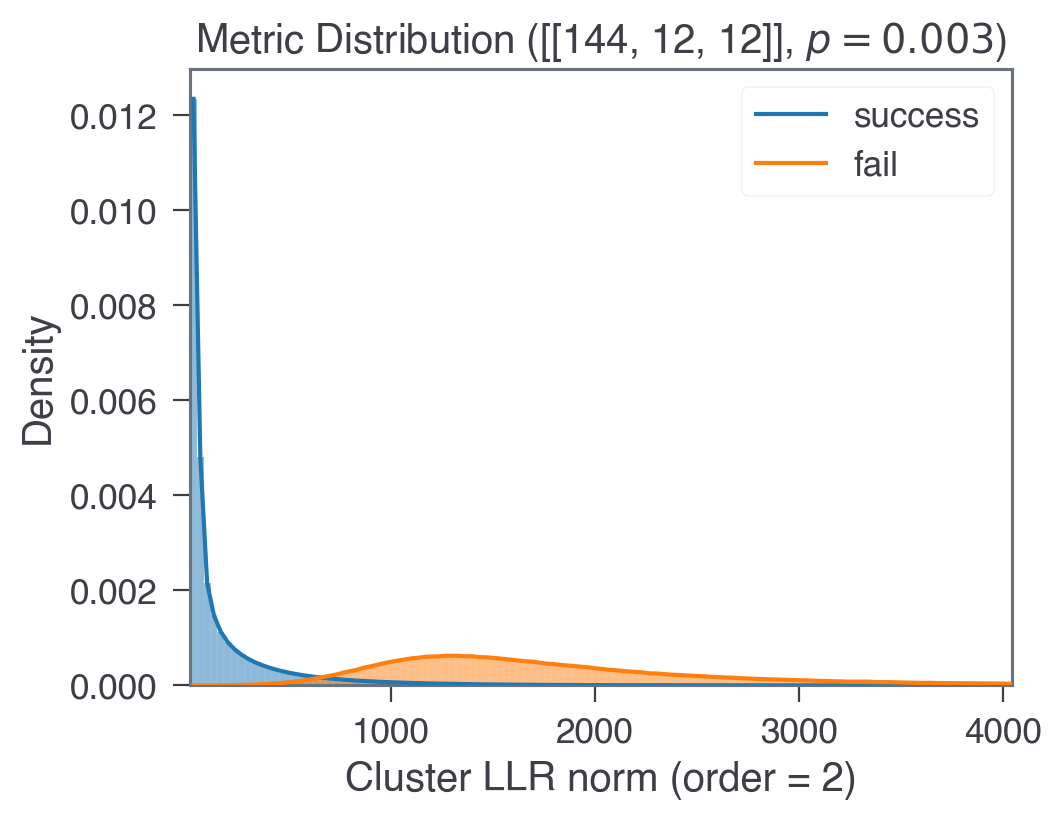

In [40]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

by = "cluster_llr_norm_2"
# by = "matching_gap"
# by = "pred_llr"
n = 144
d = {72: 6, 144: 12}[n]
p = 3e-3

df_agg = df_agg_dict[by].loc[(n, d, p)]

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg,
    bins=1000,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    upper_trim_frac=5e-2,
)

ax.set_title(
    rf"Metric Distribution ([[144, 12, 12]], $p = {p}$)"
)
ax.set_xlabel(r"Cluster LLR norm (order = 2)")